# Process

In [ ]:
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import math
import imutils
import time
import dlib
import cv2
from cv2 import VideoWriter_fourcc, VideoWriter
import matplotlib.pyplot as plt
from keras_preprocessing.image import img_to_array
from keras.models import load_model


def eye_brow_distance(leye,reye):
    global points
    distq = dist.euclidean(leye,reye)
    #calculation of distance between left and right eye.
    points.append(int(distq))
    return distq

def emotion_finder(faces,frame):
    global emotion_classifier
    EMOTIONS = ["angry" ,"disgust","fear", "happy", "sad", "surprise","neutral"]
    x,y,w,h = face_utils.rect_to_bb(faces)
    frame = frame[y:y+h,x:x+w]
    roi = cv2.resize(frame,(64,64))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi,axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    if label in ['fear','sad', 'neutral']:
        label = 'stressed'
    else:
        label = 'not stressed'
    return label
    
def normalize_values(points,disp):
    normalized_value = abs(disp - np.min(points))/abs(np.max(points) - np.min(points))
    print(abs(np.max(points) - np.min(points)))
    stress_value = np.exp(-(normalized_value))
    return stress_value



detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
print(emotion_classifier, flush = True)
cap = cv2.VideoCapture('./Video/input_video.mp4')
if not cap.isOpened():
    print("Cannot open camera")
    exit()

points = []
stress_list = []
stressval_list = []
stressgraph = []
size=0
while(True):
    _,frame = cap.read()

    if(not _): break
    frame = cv2.flip(frame,1)
    frame = imutils.resize(frame, width=500,height=500)
    
    
    (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
    (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]

    #preprocessing the image
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    detections = detector(gray,0)

    for detection in detections:

        emotion = emotion_finder(detection,gray)
        cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        shape = predictor(frame,detection)
        shape = face_utils.shape_to_np(shape)
        
        leyebrow = shape[lBegin:lEnd]
        reyebrow = shape[rBegin:rEnd]
            
        reyebrowhull = cv2.convexHull(reyebrow)
        leyebrowhull = cv2.convexHull(leyebrow)

        cv2.drawContours(frame, [reyebrowhull], -1, (0, 0, 255), 1)
        cv2.drawContours(frame, [leyebrowhull], -1, (0, 0, 255), 1)

        distq = eye_brow_distance(leyebrow[-1],reyebrow[0])
        stress_value = normalize_values(points,distq)
        print(stress_value)
        #if stress_value!=1.0: stress_list.append(stress_list)
        if math.isnan(stress_value):
            continue
        #cv2.putText(frame,"stress level:{}".format(str(int(stress_value*100))),(20,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        #stress_list.append(frame)
        cv2.putText(frame,"stress level:{}".format(str(int(stress_value*100))),(20,40),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        stress_list.append(frame)
    height, width, layers = frame.shape
    # width = int(frame.shape[1])
    # height = int(frame.shape[0])
    # size = (width,height)
    stressval_list.append(stress_value)
out = cv2.VideoWriter('resvid.avi',VideoWriter_fourcc(*'DIVX'), 10, (width,height))
cap.release()
print("END REACHED")
for i in range(len(stress_list)):
    out.write(stress_list[i])

# Training the model ;)

In [2]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

num_classes = 7 # number of labels
img_rows,img_cols = 48,48
batch_size = 32 #number of traning example utlized in 1 iteration

train_data_dir = 'train'
validation_data_dir = 'test'

train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)


model = Sequential()

# LAYER 1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# LAYER 2

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# LAYER 3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


# LAYER 4

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# LAYER 5

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# LAYER 6

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 

In [3]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('Users/Stress/Emotion_little_vgg.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 24176
nb_validation_samples = 3006
epochs=25

history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

model.save('trained_model.hdf5')

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_22888\2863385656.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/25
755/755 [==============================] - ETA: 0s - loss: 2.1834 - accuracy: 0.1954
Epoch 1: val_loss improved from inf to 1.80292, saving model to Users/Stress\Emotion_little_vgg.h5
755/755 [==============================] - 725s 957ms/step - loss: 2.1834 - accuracy: 0.1954 - val_loss: 1.8029 - val_accuracy: 0.2480 - lr: 0.0010
Epoch 2/25
755/755 [==============================] - ETA: 0s - loss: 1.8370 - accuracy: 0.2270
Epoch 2: val_loss improved from 1.80292 to 1.78773, saving model to Users/Stress\Emotion_little_vgg.h5
755/755 [==============================] - 282s 373ms/step - loss: 1.8370 - accuracy: 0.2270 - val_loss: 1.7877 - val_accuracy: 0.2544 - lr: 0.0010
Epoch 3/25
755/755 [==============================] - ETA: 0s - loss: 1.7958 - accuracy: 0.2502
Epoch 3: val_loss improved from 1.78773 to 1.76214, saving model to Users/Stress\Emotion_little_vgg.h5
755/755 [==============================] - 217s 287ms/step - loss: 1.7958 - accuracy: 0.2502 - val_loss: 1.7621

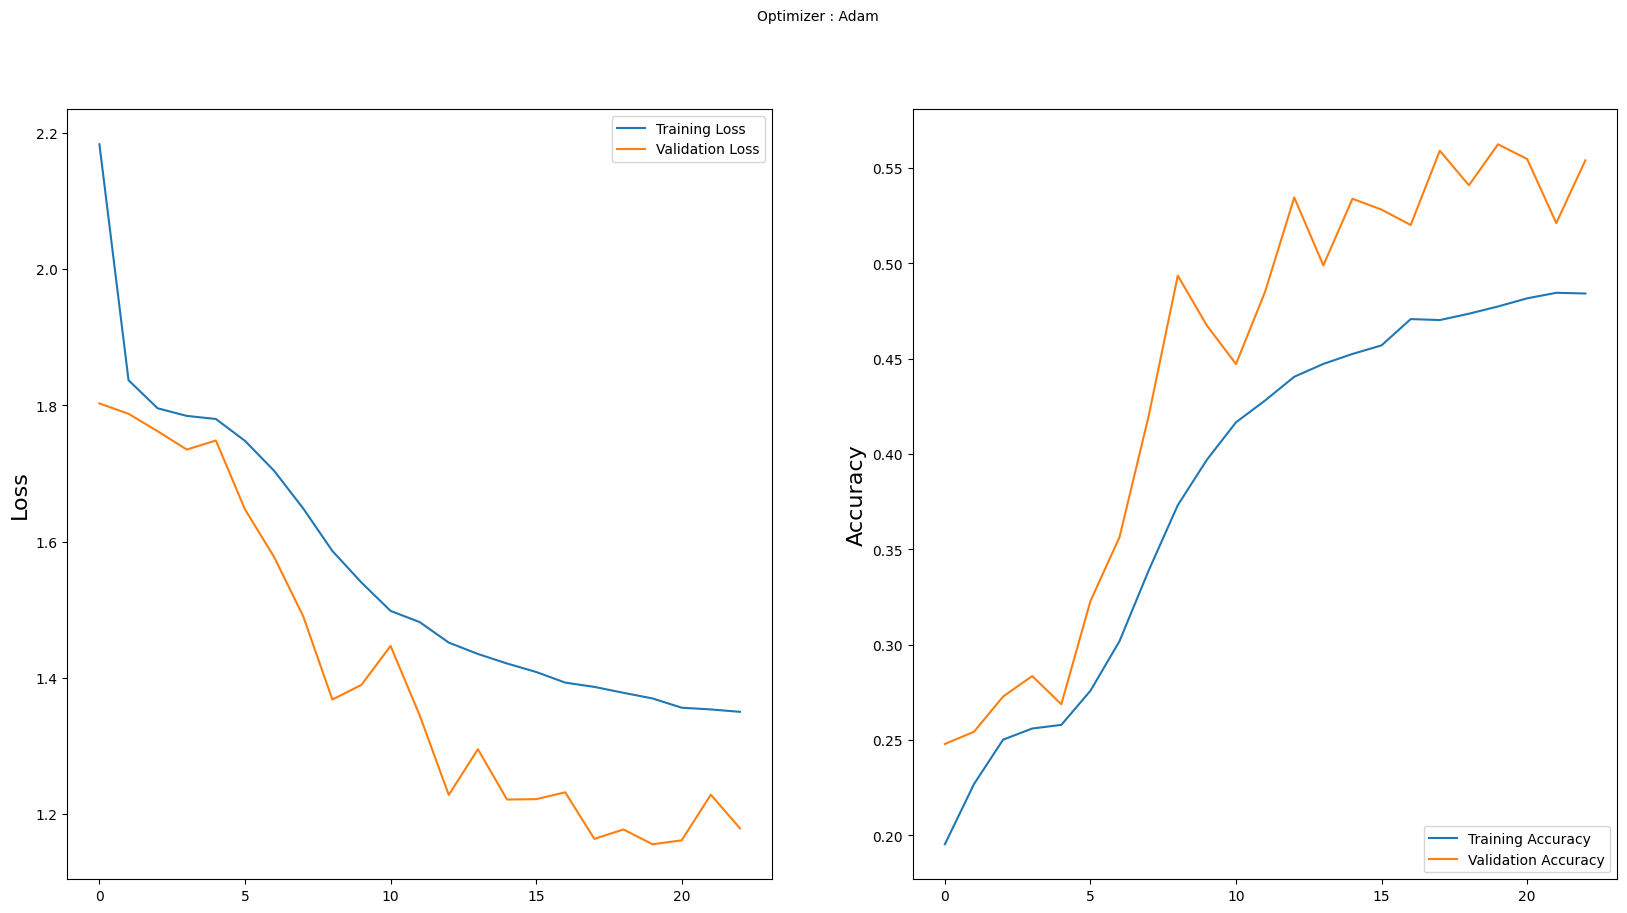

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Testing :)

In [8]:
from keras_preprocessing.image import img_to_array
import cv2
from keras.models import load_model
import numpy as np
# loading files
haar_file="haarcascade_frontalface_default.xml"
emotion_model='_mini_XCEPTION.102-0.66.hdf5'

cascade=cv2.CascadeClassifier(cv2.data.haarcascades + haar_file)
emotion_classifier=load_model(emotion_model,compile=True)
emotion_names=["angry","disgust","fear", "happy", "sad", "surprise","neutral"]
frame=cv2.imread('images/Astha.jpeg')
# frame=cv2.imread('images/sad_face.png')
#frame=cv2.imread('images/me_happy2.jpg')
gray_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces=cascade.detectMultiScale(gray_frame,1.5,5)
text=[]
for (x,y,w,h) in faces:
    roi=gray_frame[y:y+h,x:x+w]
    roi=cv2.resize(roi,(64,64))
    roi=roi.astype("float")/255.0
    roi=img_to_array(roi)
    roi=np.expand_dims(roi,axis=0)
    
    predicted_emotion=emotion_classifier.predict(roi)[0]
    probab=np.max(predicted_emotion)
    label=emotion_names[predicted_emotion.argmax()]
    percen=predicted_emotion*100
    for j in range(7):
        text.append(emotion_names[j]+" : "+str(percen[j]))
    for i in range(7):    
        #cv2.putText(frame,text[i],(5,i*30+15),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,255),2)
        print(text[i])
    cv2.putText(frame,label,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),1)
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
cv2.imwrite('images/result.jpg', frame)

1/1 [==============================] - 0s 247ms/step
angry : 0.17465751
disgust : 0.00039097626
fear : 0.46105632
happy : 83.72958
sad : 0.76513535
surprise : 0.17683424
neutral : 14.692349


True

# Recomendation ;)

In [9]:
from playsound import playsound

In [11]:
#labels = ["happy", "angry", "fear", "disgust", "sad", "surprised", "neutral"]
#label = "sad"
tips = {"fear":["Drink water","Get a good night's sleep","Eat wholesome meals","Go for a walk","Turn off news feed/social media","Talk to someone"],
        "angry":["Repeat gentle phrases to yourself","Take a walk","Use visualization to calm down","Focus on your breathing","Phone a friend","Watch a stand up comedy"],
        "sad":["Do things you enjoy (or used to)","Get quality exercise","Eat a nutritious diet","Challenge negative thinking"]
       }
website_links = {"fear":["https://www.businessinsider.in/science/health/heres-how-to-take-care-of-yourself-if-youre-feeling-scared-or-sad-right-now/articleshow/55342883.cms","https://mhanational.org/what-can-i-do-when-im-afraid"],
                 "angry":["https://www.thehotline.org/resources/how-to-cool-off-when-youre-angry/","https://www.mayoclinic.org/healthy-lifestyle/adult-health/in-depth/anger-management/art-20045434"],
                 "sad":["https://www.vandrevalafoundation.com/","https://www.healthline.com/health/depression/recognizing-symptoms#fatigue"]
                }
youtube_links = {"fear":["https://www.youtube.com/watch?v=IAODG6KaNBc"],
                 "angry":["https://www.youtube.com/watch?v=P6aPg3YBvBQ"],
                 "sad":["https://www.youtube.com/watch?v=P6aPg3YBvBQ"]
                }
song_links = {"fear":["https://www.youtube.com/watch?v=GyA8ccqwp-4&feature=youtu.be","https://www.bing.com/videos/search?q=alone+part+2&docid=607990227673701963&mid=1B6860319511BF2C5CC21B6860319511BF2C5CC2&view=detail&FORM=VIRE"],
              "angry":["https://www.youtube.com/watch?v=e74wLJ_KRes&feature=youtu.be","https://www.youtube.com/watch?v=JwWz-94a_Hk&feature=youtu.be"],
              "sad":["https://www.youtube.com/watch?v=25ROFXjoaAU&feature=youtu.be","https://www.youtube.com/watch?v=BzE1mX4Px0I"],
              "happy":["https://www.youtube.com/watch?v=vGZhMIXH62M","https://www.youtube.com/watch?v=Pkh8UtuejGw"]
             }
path = 'E:/Sem6/OSP/Stress-Detection-and-Recommendation/'
tunes = {"fear":'./Music/Fear.mp3',
         "angry":'./Music/Angry.mp3',
         "sad":'./Music/Sad.mp3'
         }

if (label == "happy"):
    # songs
    print("Here are some song suggestions for your mood:")
    for s in song_links.get('happy'):
        print(s)

elif (label == "angry"):
    # songs
    print("Here are some song suggestions for your mood:")
    for s in song_links.get('angry'):
        print(s)
    # tips
    print("Here are some tips to help you feel better:")
    for i in tips.get('angry'):
        print("-> "+i)
    # resources
    print("Here are some resources that you may find beneficial:")
    for j in website_links.get('angry'):
        print(j)
    for k in youtube_links.get('angry'):
        print(k)
    # tunes
    print("Here's a tune that will help you calm down.")
    playsound(tunes.get('angry'))

elif (label == "fear"):
    # songs
    print("Here are some song suggestions for your mood:")
    for s in song_links.get('fear'):
        print(s)
    # tips
    print("Here are some tips to help you feel better:")
    for i in tips.get('fear'):
        print("-> "+i)
    # resources
    print("Here are some resources that you may find beneficial:")
    for j in website_links.get('fear'):
        print(j)
    for k in youtube_links.get('fear'):
        print(k)
    # tunes
    print("Here's a tune that will make you feel better.")
    playsound(tunes.get('fear'))

elif (label == "sad"):
    # songs
    print("Here are some song suggestions for your mood:")
    for s in song_links.get('sad'):
        print(s)
    # tips
    print("Here are some tips to help you feel better:")
    for i in tips.get('sad'):
        print("-> "+i)
    # resources
    print("Here are some resources that you may find beneficial:")
    for j in website_links.get('sad'):
        print(j)
    for k in youtube_links.get('sad'):
        print(k)
    # tunes
    print("Listen to a tune that will soothe you.")
    playsound(tunes.get('sad'))

Here are some song suggestions for your mood:
https://www.youtube.com/watch?v=vGZhMIXH62M
https://www.youtube.com/watch?v=Pkh8UtuejGw
